In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to the same size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

In [32]:
traindataset = datasets.ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/Jute_Pest_Dataset/train', transform=transform)
valdataset = datasets.ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/Jute_Pest_Dataset/val', transform=transform)


In [33]:
train_loader = DataLoader(traindataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(valdataset, batch_size=32, shuffle=False, num_workers=4)


In [6]:
folder_path = '/kaggle/input/jute-pest/Jute_Pest_Dataset/Jute_Pest_Dataset/train'
class_names = [folder for folder in os.listdir(folder_path) 
                       if os.path.isdir(os.path.join(folder_path, folder))]
len(class_names)

17

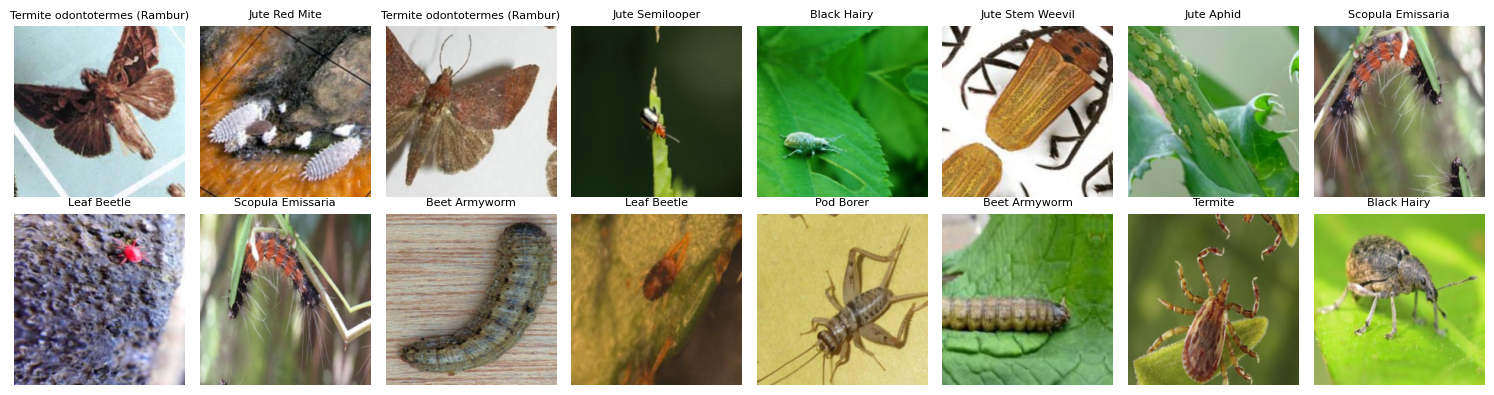

In [34]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def plot_batch(dataloader, classes):
    """
    Plots one batch of images from the DataLoader with labels under each image.

    Args:
        dataloader (DataLoader): The DataLoader object.
        classes (list): List of class names corresponding to labels.
    """
    # Get one batch of data
    images, labels = next(iter(dataloader))
    
    # Denormalize images if normalization was applied
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean  # Denormalize images
    
    # Plot each image with its label
    batch_size = 16
    cols = 8  # Number of images per row
    rows = (batch_size + cols - 1) // cols  # Calculate the required number of rows
    
    plt.figure(figsize=(15, rows * 2))  # Adjust figure size based on rows
    for idx in range(batch_size):
        plt.subplot(rows, cols, idx + 1)
        img = images[idx].permute(1, 2, 0).numpy()  # Rearrange dimensions for matplotlib
        plt.imshow(img)
        plt.axis('off')  # Remove axes for better visualization
        label = classes[labels[idx].item()]  # Convert label index to class name
        plt.title(label, fontsize=8)  # Display label below the image
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_batch(train_loader, class_names)


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvoluNet(nn.Module):
    def __init__(self, num_classes=17):
        super(ConvoluNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # (batch_size, 32, 224, 224)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # (batch_size, 64, 224, 224)
        self.relu2 = nn.ReLU()  # (batch_size, 64, 224, 224)
        self.bn2 = nn.BatchNorm2d(64)  # (batch_size, 64, 224, 224)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 64, 112, 112)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # (batch_size, 128, 112, 112)
        self.relu3 = nn.ReLU()  # (batch_size, 128, 112, 112)
        self.bn3 = nn.BatchNorm2d(128)  # (batch_size, 128, 112, 112)
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 128, 56, 56)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # (batch_size, 256, 56, 56)
        self.relu4 = nn.ReLU()  # (batch_size, 256, 56, 56)
        self.bn4 = nn.BatchNorm2d(256)  # (batch_size, 256, 56, 56)
        self.pool4 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 256, 28, 28)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)  # (batch_size, 512, 28, 28)
        self.relu5 = nn.ReLU()  # (batch_size, 512, 28, 28)
        self.bn5 = nn.BatchNorm2d(512)  # (batch_size, 512, 28, 28)
        self.pool5 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 512, 14, 14)

        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)  # (batch_size, 512, 14, 14)
        self.relu6 = nn.ReLU()  # (batch_size, 512, 14, 14)
        self.bn6 = nn.BatchNorm2d(512)  # (batch_size, 512, 14, 14)
        self.pool6 = nn.MaxPool2d(kernel_size=2)  # (batch_size, 512, 7, 7)

        self.dropout = nn.Dropout(p=0.25)  # (batch_size, 512, 7, 7)

        self.flatten = nn.Flatten()  # (batch_size, 512 * 7 * 7 = 25088)

        self.fc1 = nn.Linear(in_features=7 * 7 * 512, out_features=1024)  # (batch_size, 1024)
        self.relu_fc1 = nn.ReLU()  # (batch_size, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)  # (batch_size, 1024)
        
        self.fc2 = nn.Linear(in_features=1024, out_features=512)  # (batch_size, 512)
        self.relu_fc2 = nn.ReLU()  # (batch_size, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)  # (batch_size, 512)
      
        self.fc3 = nn.Linear(in_features=512, out_features=256)  # (batch_size, 256)
        self.relu_fc3 = nn.ReLU()  # (batch_size, 256)
        self.bn_fc3 = nn.BatchNorm1d(256)  # (batch_size, 256)
        
        self.fc4 = nn.Linear(in_features=256, out_features=128)  # (batch_size, 128)
        self.relu_fc4 = nn.ReLU()  # (batch_size, 128)
        self.bn_fc4 = nn.BatchNorm1d(128)  # (batch_size, 128)
     
        self.fc5 = nn.Linear(in_features=128, out_features=32)  # (batch_size, 32)
        self.relu_fc5 = nn.ReLU()  # (batch_size, 32)
        self.bn_fc5 = nn.BatchNorm1d(32)  # (batch_size, 32)

        self.fc6 = nn.Linear(in_features=32, out_features=num_classes)  # (batch_size, num_classes)
        
    def forward(self, input):
        output = self.conv1(input)  # (batch_size, 32, 224, 224)
        output = self.conv2(output)  # (batch_size, 64, 224, 224)
        output = self.relu2(output)  # (batch_size, 64, 224, 224)
        output = self.bn2(output)  # (batch_size, 64, 224, 224)
        output = self.pool2(output)  # (batch_size, 64, 112, 112)
    
        output = self.conv3(output)  # (batch_size, 128, 112, 112)
        output = self.relu3(output)  # (batch_size, 128, 112, 112)
        output = self.bn3(output)  # (batch_size, 128, 112, 112)
        output = self.pool3(output)  # (batch_size, 128, 56, 56)
     
        output = self.conv4(output)  # (batch_size, 256, 56, 56)
        output = self.relu4(output)  # (batch_size, 256, 56, 56)
        output = self.bn4(output)  # (batch_size, 256, 56, 56)
        output = self.pool4(output)  # (batch_size, 256, 28, 28)

        output = self.conv5(output)  # (batch_size, 512, 28, 28)
        output = self.relu5(output)  # (batch_size, 512, 28, 28)
        output = self.bn5(output)  # (batch_size, 512, 28, 28)
        output = self.pool5(output)  # (batch_size, 512, 14, 14)

        output = self.conv6(output)  # (batch_size, 512, 14, 14)
        output = self.relu6(output)  # (batch_size, 512, 14, 14)
        output = self.bn6(output)  # (batch_size, 512, 14, 14)
        output = self.pool6(output)  # (batch_size, 512, 7, 7)

        output = self.dropout(output)  # (batch_size, 512, 7, 7)

        output = self.flatten(output)  # (batch_size, 25088)

        output = self.fc1(output)  # (batch_size, 1024)
        output = self.relu_fc1(output)  # (batch_size, 1024)
        output = self.bn_fc1(output)  # (batch_size, 1024)
     
        output = self.fc2(output)  # (batch_size, 512)
        output = self.relu_fc2(output)  # (batch_size, 512)
        output = self.bn_fc2(output)  # (batch_size, 512)
  
        output = self.fc3(output)  # (batch_size, 256)
        output = self.relu_fc3(output)  # (batch_size, 256)
        output = self.bn_fc3(output)  # (batch_size, 256)

        output = self.fc4(output)  # (batch_size, 128)
        output = self.relu_fc4(output)  # (batch_size, 128)
        output = self.bn_fc4(output)  # (batch_size, 128)
 
        output = self.fc5(output)  # (batch_size, 32)
        output = self.relu_fc5(output)  # (batch_size, 32)
        output = self.bn_fc5(output)  # (batch_size, 32)
          
        output = self.fc6(output)  # (batch_size, num_classes)

        # No need for softmax here if using CrossEntropyLoss
        # output = F.softmax(output, dim=1)  # (batch_size, num_classes)

        return output

In [10]:
!pip install torchsummary

In [11]:
from torchsummary import summary

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
print(device)

cuda


In [38]:
model = ConvoluNet(num_classes =17).to(device)

In [39]:
from torch.optim import Adam
optimizer=Adam(model.parameters(),lr=0.0001,weight_decay=1e-5)
loss_function=nn.CrossEntropyLoss()

In [40]:
epochs = 20

In [41]:
from tqdm import tqdm


def train(model, optimizer, loss_function, train_loader, epoch, epochs, train_count):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

    for i, (images, labels) in enumerate(train_bar):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item() * images.size(0)  
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += torch.sum(prediction == labels.data).item()

        train_bar.set_postfix(train_loss=train_loss, train_accuracy=train_accuracy)

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    return train_loss, train_accuracy

def validate(model, val_loader, val_count):
    model.eval()
    val_accuracy = 0.0
    val_loss = 0.0

    for i, (images, labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        val_loss += loss.item() * images.size(0)
        
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy += torch.sum(prediction == labels.data).item()

    val_loss = val_loss / val_count
    val_accuracy = val_accuracy / val_count

    return val_loss, val_accuracy

In [42]:
train_count = len(traindataset)
val_count = len(valdataset)

In [43]:
import matplotlib.pyplot as plt

# Initialize lists to store values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_accuracy = 0.0

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, optimizer, loss_function, train_loader, epoch, epochs, train_count)
    val_loss, val_accuracy = validate(model, val_loader, val_count)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print('Epoch: ' + str(epoch + 1) + ' Train Loss: ' + str(train_loss) + ' Train Accuracy: ' + str(train_accuracy) + ' Validation Accuracy: ' + str(val_accuracy))

Epoch: 1 Train Loss: 2.2345152990482076 Train Accuracy: 0.36312849162011174 Validation Accuracy: 0.38498789346246975


Epoch: 2 Train Loss: 1.7041081221927996 Train Accuracy: 0.5878336436995655 Validation Accuracy: 0.5326876513317191


Epoch: 3 Train Loss: 1.331193346920996 Train Accuracy: 0.7217566728739913 Validation Accuracy: 0.5811138014527845


Epoch: 4 Train Loss: 1.0506041873544731 Train Accuracy: 0.8069522036002483 Validation Accuracy: 0.6271186440677966


Epoch: 5 Train Loss: 0.8053353341154103 Train Accuracy: 0.8729050279329609 Validation Accuracy: 0.6319612590799032


Epoch: 6 Train Loss: 0.6646204720662293 Train Accuracy: 0.8950962135319678 Validation Accuracy: 0.6755447941888619


Epoch: 7 Train Loss: 0.5047154963053508 Train Accuracy: 0.9293916821849783 Validation Accuracy: 0.6755447941888619


Epoch: 8 Train Loss: 0.41131069950995275 Train Accuracy: 0.9418063314711359 Validation Accuracy: 0.6876513317191283


Epoch: 9 Train Loss: 0.31302862545483456 Train Accuracy: 0.9608938547486033 Validation Accuracy: 0.7239709443099274


Epoch: 10 Train Loss: 0.2724515776838448 Train Accuracy: 0.9653941651148356 Validation Accuracy: 0.6561743341404358


Epoch: 11 Train Loss: 0.2424345069757387 Train Accuracy: 0.9644630664183736 Validation Accuracy: 0.7094430992736077


Epoch: 12 Train Loss: 0.22106611539975668 Train Accuracy: 0.9657045313469894 Validation Accuracy: 0.7215496368038741


Epoch: 13 Train Loss: 0.18165217435263759 Train Accuracy: 0.9745499689633768 Validation Accuracy: 0.7021791767554479


Epoch: 14 Train Loss: 0.14855369285886735 Train Accuracy: 0.9812228429546865 Validation Accuracy: 0.7239709443099274


Epoch: 15 Train Loss: 0.1380576042933615 Train Accuracy: 0.9795158286778398 Validation Accuracy: 0.6924939467312349


Epoch: 16 Train Loss: 0.14458836634509833 Train Accuracy: 0.9751707014276847 Validation Accuracy: 0.7094430992736077


Epoch: 17 Train Loss: 0.12125048265184844 Train Accuracy: 0.9773432650527623 Validation Accuracy: 0.6343825665859564


Epoch: 18 Train Loss: 0.3163114620024636 Train Accuracy: 0.9155803848541278 Validation Accuracy: 0.6924939467312349


Epoch: 19 Train Loss: 0.1243862786846528 Train Accuracy: 0.9768777157045313 Validation Accuracy: 0.7191283292978208


Epoch: 20 Train Loss: 0.0729789300541342 Train Accuracy: 0.9897579143389199 Validation Accuracy: 0.711864406779661


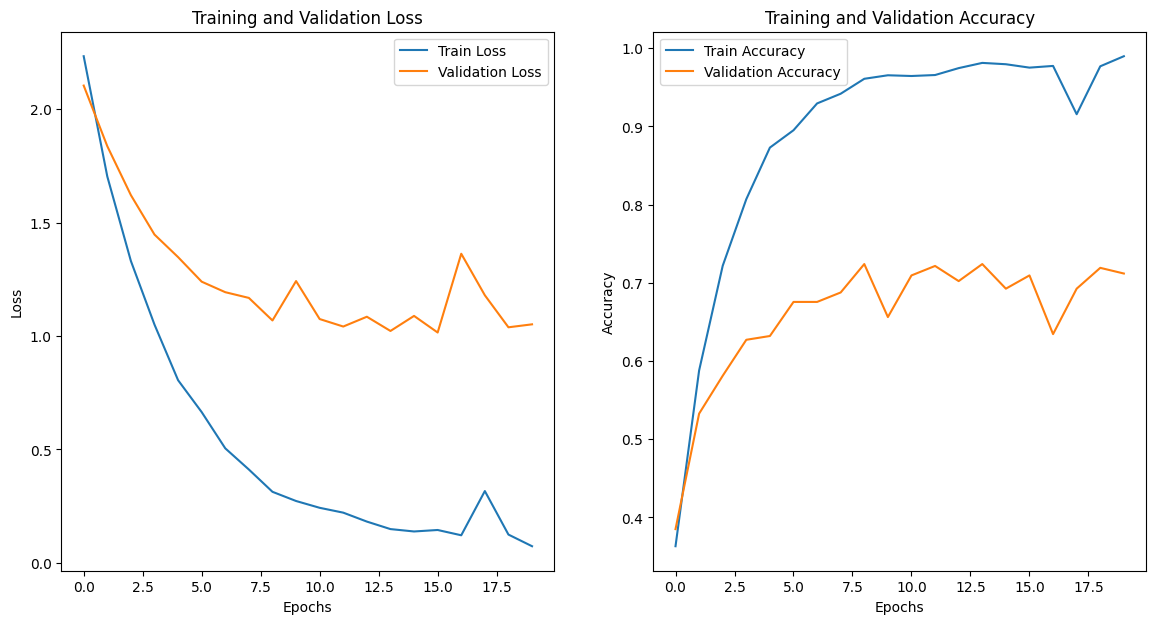

In [44]:
epochs_range = range(epochs)

plt.figure(figsize=(14, 7))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label
         ='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [45]:
testdataset = datasets.ImageFolder(root='/kaggle/input/jute-pest/Jute_Pest_Dataset/Jute_Pest_Dataset/test', transform=transform)
test_loader = DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=4)


Test Loss: 0.4824, Test Accuracy: 86.81%

Classification Report:
Class 0: Precision: 0.73, Recall: 0.40, F1-Score: 0.52
Class 1: Precision: 0.76, Recall: 0.95, F1-Score: 0.84
Class 2: Precision: 0.86, Recall: 0.95, F1-Score: 0.90
Class 3: Precision: 0.83, Recall: 1.00, F1-Score: 0.91
Class 4: Precision: 0.79, Recall: 0.68, F1-Score: 0.73
Class 5: Precision: 0.83, Recall: 0.75, F1-Score: 0.79
Class 6: Precision: 1.00, Recall: 0.75, F1-Score: 0.86
Class 7: Precision: 0.89, Recall: 0.81, F1-Score: 0.85
Class 8: Precision: 1.00, Recall: 0.92, F1-Score: 0.96
Class 9: Precision: 0.73, Recall: 0.92, F1-Score: 0.81
Class 10: Precision: 0.92, Recall: 1.00, F1-Score: 0.96
Class 11: Precision: 0.90, Recall: 0.75, F1-Score: 0.82
Class 12: Precision: 0.96, Recall: 1.00, F1-Score: 0.98
Class 13: Precision: 0.96, Recall: 1.00, F1-Score: 0.98
Class 14: Precision: 1.00, Recall: 0.95, F1-Score: 0.97
Class 15: Precision: 0.92, Recall: 1.00, F1-Score: 0.96
Class 16: Precision: 0.70, Recall: 0.88, F1-Score

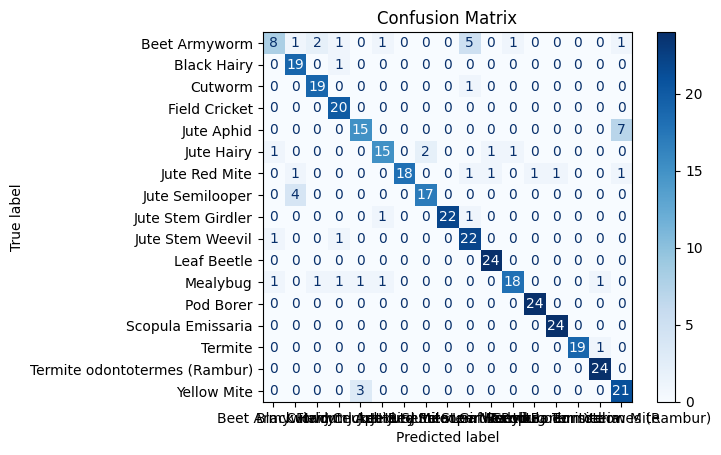

In [46]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Define the test function with metrics
def test_with_metrics(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            # Predictions and labels
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss / total
    test_accuracy = correct / total

    # Convert lists to NumPy arrays for metrics computation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions, output_dict=True)

    return test_loss, test_accuracy, conf_matrix, class_report

# Evaluate the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()  # Replace with your training loss function if different
model.to(device)

test_loss, test_accuracy, conf_matrix, class_report = test_with_metrics(model, test_loader, criterion, device)

# Display Results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
for label, metrics in class_report.items():
    if isinstance(metrics, dict):  # Skip 'accuracy' key
        precision = metrics['precision']
        recall = metrics['recall']
        f1_score = metrics['f1-score']
        print(f"Class {label}: Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_loader.dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
